In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

##### Load Daniel Shan Balico's dataset.
- Carry out a train-validation split using sci-kit learn.
- Reshape images to (3, 224, 224), flatten and load into 'trainimages', 'valimages' and 'testimages' array.
- Subsequently store labels into 'trainlabels', 'valimages' and 'testlabels' array.

In [3]:
dataframe = pd.read_csv('data/Daniel_Shan_Balico/labels.csv')
dataframe.info()
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4000 non-null   int64 
 1   filename    4000 non-null   object
 2   label       4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


,Unnamed: 0,filename,label
0,0,yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg,sad
1,1,c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg,sad
2,2,RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg,angry
3,3,gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg,angry
4,4,U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg,relaxed


##### Create Stratified Shuffle Split on labels dataframe.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_val_index, test_index in sss.split(dataframe, dataframe['label']):
    train_val_set = dataframe.loc[train_val_index]
    test_set = dataframe.loc[test_index]

In [5]:
for train_index, val_index in sss.split(train_val_set, train_val_set['label']):
    train_set = dataframe.loc[train_index]
    val_set = dataframe.loc[val_index]

##### Get graphings.

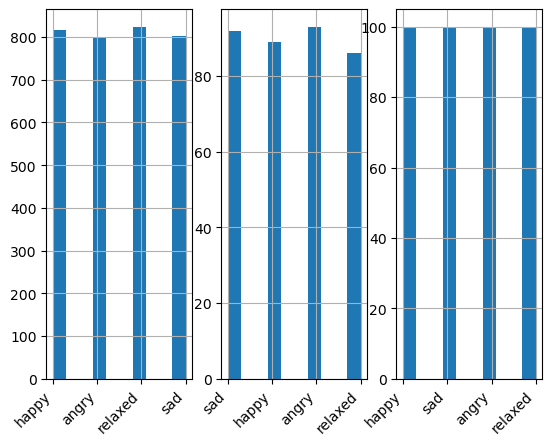

In [6]:
plt.subplot(1, 3, 1)
train_set['label'].hist()
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
val_set['label'].hist()
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
test_set['label'].hist()
plt.xticks(rotation=45, ha='right')

plt.show()

In [7]:
print('Train Examples:', train_set.shape[0])
print('Validation Examples:', val_set.shape[0])
print('Test Examples:', test_set.shape[0])

Train Examples: 3240
Validation Examples: 360
Test Examples: 400


##### Feed the images into the arrays.

In [8]:
trimages = np.array([], dtype=np.uint8).reshape((0, 3, 192, 192))
valimages = np.array([], dtype=np.uint8).reshape((0, 3, 192, 192))
testimages = np.array([], dtype=np.uint8).reshape((0, 3, 192, 192))
trlabels = np.array([])
vallabels = np.array([])
testlabels = np.array([])

label_dict = {'angry' : 0,
              'happy' : 1,
              'relaxed' : 2,
              'sad' : 3}

In [9]:
for index in tqdm(train_set.index):
    img = Image.open('data/Daniel_Shan_Balico/all_images/' + train_set['filename'][index])
    img = img.resize((192, 192))
    img = np.asarray(img)
    img = np.transpose(img, (2,0,1))
    img = img.reshape(1, 3, 192, 192)
    trimages = np.append(trimages, img, axis = 0)
    trlabels = np.append(trlabels, label_dict[train_set['label'][index]])

for index in tqdm(val_set.index):
    img = Image.open('data/Daniel_Shan_Balico/all_images/' + val_set['filename'][index])
    img = img.resize((192, 192))
    img = np.asarray(img)
    img = np.transpose(img, (2,0,1))
    img = img.reshape(1, 3, 192, 192)
    valimages = np.append(valimages, img, axis = 0)
    vallabels = np.append(vallabels, label_dict[val_set['label'][index]])

for index in tqdm(test_set.index):
    img = Image.open('data/Daniel_Shan_Balico/all_images/' + test_set['filename'][index])
    img = img.resize((192, 192))
    img = np.asarray(img)
    img = np.transpose(img, (2,0,1))
    img = img.reshape(1, 3, 192, 192)
    testimages = np.append(testimages, img, axis = 0)
    testlabels = np.append(testlabels, label_dict[test_set['label'][index]])

100%|██████████| 400/400 [00:02<00:00, 197.36it/s]


In [10]:
np.save('data/Daniel_Shan_Balico/numpy_arrays_192/trimages', trimages)
np.save('data/Daniel_Shan_Balico/numpy_arrays_192/valimages', valimages)
np.save('data/Daniel_Shan_Balico/numpy_arrays_192/testimages', testimages)
np.save('data/Daniel_Shan_Balico/numpy_arrays_192/trlabels', trlabels)
np.save('data/Daniel_Shan_Balico/numpy_arrays_192/vallabels', vallabels)
np.save('data/Daniel_Shan_Balico/numpy_arrays_192/testlabels', testlabels)

In [11]:
trimages = np.load('data/Daniel_Shan_Balico/numpy_arrays_192/trimages.npy')
valimages = np.load('data/Daniel_Shan_Balico/numpy_arrays_192/valimages.npy')
testimages = np.load('data/Daniel_Shan_Balico/numpy_arrays_192/testimages.npy')
trlabels = np.load('data/Daniel_Shan_Balico/numpy_arrays_192/trlabels.npy')
vallabels = np.load('data/Daniel_Shan_Balico/numpy_arrays_192/vallabels.npy')
testlabels = np.load('data/Daniel_Shan_Balico/numpy_arrays_192/testlabels.npy')

In [12]:
MEAN = np.mean(trimages/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(trimages/255.0,axis=(0,2,3),keepdims=True)
print(MEAN)
print(STD)

[[[[0.47366378]]

  [[0.44025252]]

  [[0.38664348]]]]
[[[[0.26858465]]

  [[0.26024857]]

  [[0.26190903]]]]


##### Data generator.
- All augmentations performed as listed in the SimCLR paper https://arxiv.org/abs/2002.05709.

In [13]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop((192, 192),(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

In [14]:
dg = C10DataGen('train',trimages)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

vdg = C10DataGen('valid',valimages)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

##### Set up model.
- The Identity module gives output what it takes as input.
- The LinearLayer module gives a single Linear layer followed by an optional BatchNormalization layer.
- The ProjectionHead module gives a linear or non-linear projection head according to the argument passed.
- The PreModel module gives the model to be used for pre-training, i.e. the base encoder f(.) with an MLP g(.) on top of it. 
- The class PreModel uses ResNet50. However, this can be modified according to your need and can even be made customizable with some little extra work.

In [15]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model):
        super().__init__()
        self.base_model = base_model
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)
        
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(2048, 2048, 128)

    def forward(self,x):
        out = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp

In [16]:
model = PreModel('resnet50').to('cuda:0')

/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### Loss Function.
- The Loss function code has been taken from this repo (Spijkervet/SimCLR) and modified slightly. 

In [17]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

##### Optimizer.
- LARS Optimizer as instructed in the SimCLR paper https://arxiv.org/abs/2002.05709.
- Picked up from repo (Spijkervet/SimCLR).

In [18]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [19]:
#OPTMIZER
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


##### Utility functions.

In [20]:
def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('/saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

def plot_features(model, num_classes, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

In [21]:
import gc
torch.cuda.empty_cache()
gc.collect()

10165

##### Training Loop.

In [22]:
nr = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []

for epoch in range(100):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dl):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(dl)}]\t Loss: {round(loss.item(), 5)}")

        tr_loss_epoch += loss.item()

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(vdl):
        
          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i = model(x_i)
          z_j = model(x_j)

          loss = criterion(z_i, z_j)

          if nr == 0 and step % 50 == 0:
              print(f"Step [{step}/{len(vdl)}]\t Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    if nr == 0:
        tr_loss.append(tr_loss_epoch / len(dl))
        val_loss.append(val_loss_epoch / len(vdl))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.pretrained, 4, 2048, 128)

save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

Epoch [0/100]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.41 GiB. GPU 0 has a total capacty of 7.79 GiB of which 759.62 MiB is free. Including non-PyTorch memory, this process has 7.03 GiB memory in use. Of the allocated memory 6.82 GiB is allocated by PyTorch, and 24.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF